# IMPORTING OUR LIBRARIES AND MODULES

In [1]:
# Essential Libraries for data analysis and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Deep Learning libraries
import tensorflow as tf
import tensorflow_hub as hub

# Image Processing and Visualization
from IPython.display import display, Image
from matplotlib.pyplot import imread

# Data Spliting Module
from sklearn.model_selection import train_test_split

# Other
import os


In [2]:
# Checking that we run TensorFlow v2 and the GPU is working 
print("TF version:", tf.__version__)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.3.1
GPU available (YESS!!!!)


# Loading Data 

we are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. 



In [3]:
# Loading the labels of our data
labels_csv = pd.read_csv("../input/dog-breed-identification/labels.csv")


## Lets do fast EDA on our Labels 

In [4]:
Labels_Profile = ProfileReport(labels_csv, progress_bar= False)
Labels_Profile.to_notebook_iframe()

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Lets visualize our classes(breeds) to check for imbalance 

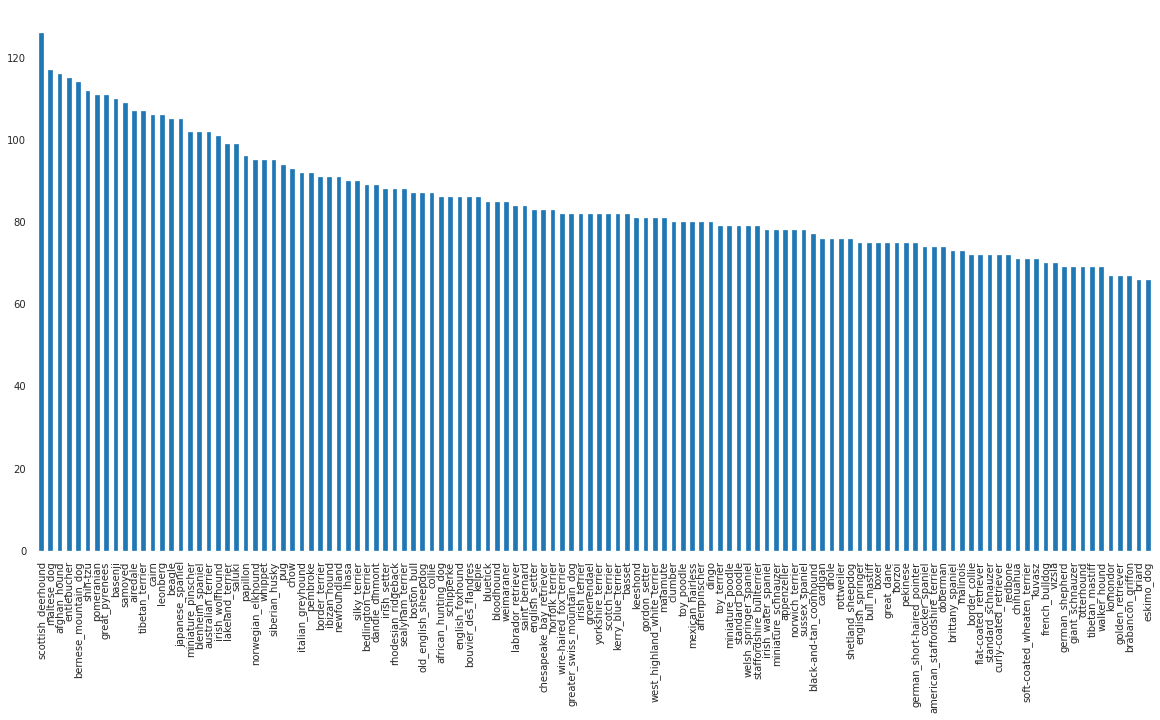

In [5]:

labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

It seems that we have no significant imbalance between classes.

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [6]:
# Create pathnames from image ID's
filenames = ["../input/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 5 filenames to see if output of our feature engineering function
filenames[:5]


['../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '../input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '../input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '../input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '../input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [7]:
# Check whether number of filenames matches number of actual image files
if len(os.listdir("../input/dog-breed-identification/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


If everything worked, we should see a match up.

Let's do one more check. Visualizing directly from a filepath.

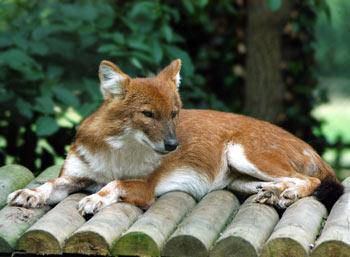

In [8]:
# Check an image directly from a filepath
Image(filenames[42])


Now we've got our image filepaths together, let's get the labels.

We'll take them from `labels_csv` and turn them into a NumPy array for handling them with numpy methods as needed

In [9]:
# convert labels column to NumPy array
labels = labels_csv["breed"].to_numpy() 
#check the first 10 elements in the label ndarray
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

now lets do the same thing as before, compare the amount of labels to number of filenames to assert that everything is working properly before moving to the next stage!

In [10]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers. 

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [11]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [12]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

### Creating our own validation set


In [13]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to for fast expermintation.
Let's start experimenting with 1000 and increase it as we need.

In [14]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing images (turning images into Tensors)




To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images). 

we resize our image into (224, 224) because this is the size of input our pre-trained model (we'll see this soon from TesnoFlow hub) takes, an image which is (224, 224, 3).

3 's the number of colour channels per pixel, red, green and blue.



**Ok, now let's build that function we were talking about.**

In [15]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches
To accelerate computing using GPU and to ingest our data into the model

In [16]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [17]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [18]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [19]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.



### Visualizing data batches

In [20]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

**Looping over our Data batch in oreder to view our images**

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.


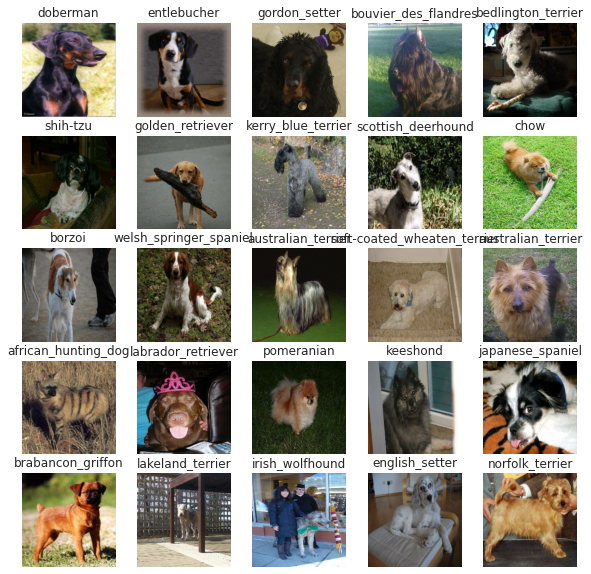

In [21]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use a pretrained model from [TensorFlow Hub](https://tfhub.dev/)(**transfer learning**).

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [22]:
# Setup input shape according to the pretrained-model input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel ass

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential style.
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.



## Building a model using Keras & TF hub APIs

In [52]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers using sequential mode.
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (the pre-trained model )
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), 
      optimizer=tf.keras.optimizers.SGD(), 
      metrics=["accuracy"] 
  )

  # Build the model
  model.build(INPUT_SHAPE) 
  
  return model

In [53]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [54]:
# Load the TensorBoard notebook extension
%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("./logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving.


In [56]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.



In [57]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


 Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.`

In [58]:
# Build a function to train and return a trained model
NUM_EPOCHS = 100 
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [59]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 4s 150ms/step - loss: 5.2213 - accuracy: 0.0250 - val_loss: 4.7293 - val_accuracy: 0.0400
Epoch 2/100
25/25 [==============================] - 3s 119ms/step - loss: 4.0677 - accuracy: 0.1175 - val_loss: 4.0208 - val_accuracy: 0.1400
Epoch 3/100
25/25 [==============================] - 3s 106ms/step - loss: 3.1626 - accuracy: 0.3000 - val_loss: 3.4752 - val_accuracy: 0.2550
Epoch 4/100
25/25 [==============================] - 3s 107ms/step - loss: 2.4785 - accuracy: 0.4588 - val_loss: 3.0538 - val_accuracy: 0.3450
Epoch 5/100
25/25 [==============================] - 3s 104ms/step - loss: 1.9776 - accuracy: 0.5850 - val_loss: 2.7269 - val_accuracy: 0.3900
Epoch 6/100
25/25 [==============================] - 3s 114ms/step - loss: 1.6040 - accuracy: 0.6812 - val_loss: 2.4712 - val_accuracy: 0.4400
Epoch 7/100
25/25 [==============================

#### Checking the TensorBoard logs
Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [60]:

%tensorboard --logdir ./logs 


Reusing TensorBoard on port 6006 (pid 1272), started 0:14:34 ago. (Use '!kill 1272' to kill it.)

## Making and evaluating predictions using a trained model

Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling `predict()` on it and passing it data in the same format the model was trained on.

In [61]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 1s 103ms/step


array([[4.54226800e-04, 1.46261693e-04, 2.43453742e-05, ...,
        1.06988366e-04, 2.47693570e-05, 1.34986057e-03],
       [3.04287160e-03, 1.20869291e-03, 6.31281640e-03, ...,
        1.21365918e-03, 2.07326794e-03, 1.12455443e-03],
       [6.26778274e-05, 1.32555899e-04, 4.13718590e-06, ...,
        3.16797777e-05, 4.47919138e-06, 1.31639605e-03],
       ...,
       [1.12162743e-05, 6.21800200e-06, 2.22516410e-05, ...,
        1.41133905e-05, 7.12778128e-05, 3.07076734e-05],
       [1.66188721e-02, 1.56844602e-04, 2.30542762e-04, ...,
        3.57398327e-04, 2.63333204e-04, 1.50265805e-02],
       [1.63992331e-03, 2.97784340e-04, 4.59534023e-03, ...,
        4.99773398e-03, 3.17978964e-04, 3.05389374e-04]], dtype=float32)

In [62]:
# Check the shape of predictions
predictions.shape

(200, 120)

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (`predictions`) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Let's see how we'd convert an array of probabilities into an actual label.

In [63]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[4.54226800e-04 1.46261693e-04 2.43453742e-05 3.22522574e-05
 1.57838840e-05 4.72076363e-06 2.89326403e-02 2.39972560e-05
 1.15793528e-05 4.51296248e-04 2.36047970e-04 6.63832407e-06
 1.02235354e-04 5.27768952e-06 5.35069594e-05 5.64495422e-05
 4.28636558e-05 1.47871440e-02 4.22571293e-06 6.03982062e-06
 4.27704159e-04 3.98369339e-05 9.61468759e-05 1.70862913e-04
 1.51626755e-05 7.54186703e-06 7.86736310e-01 3.03149113e-06
 4.39349496e-05 9.32750845e-05 1.57583694e-04 5.71870594e-04
 3.11312906e-05 4.26876722e-05 2.45348085e-04 2.65643932e-02
 2.74120521e-05 1.14457973e-04 2.46926338e-05 4.06335348e-05
 1.67983570e-04 9.19304148e-06 2.05862729e-04 1.92851312e-05
 2.64882710e-05 2.01377461e-05 5.18606521e-06 3.10053656e-05
 3.90046225e-05 1.88927908e-04 8.50382348e-05 7.70801125e-06
 3.68693465e-04 4.99362213e-05 3.14482495e-05 1.47193123e-05
 6.28778480e-06 1.52632035e-03 4.20072865e-06 3.03114895e-02
 2.62460690e-05 1.24160815e-05 9.76025040e-05 4.08586220e-06
 2.02181182e-04 1.832742

In [64]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [65]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Nailed it!

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [66]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

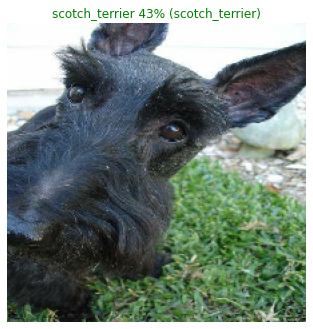

In [67]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

Nice! Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [68]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

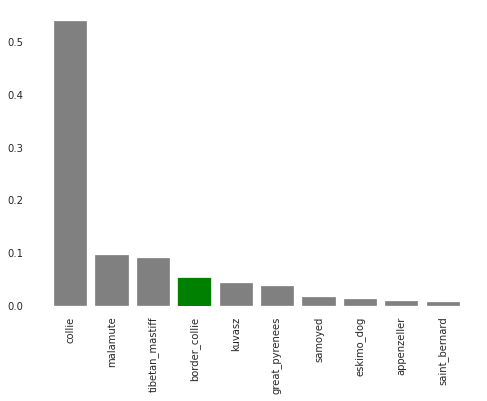

In [69]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

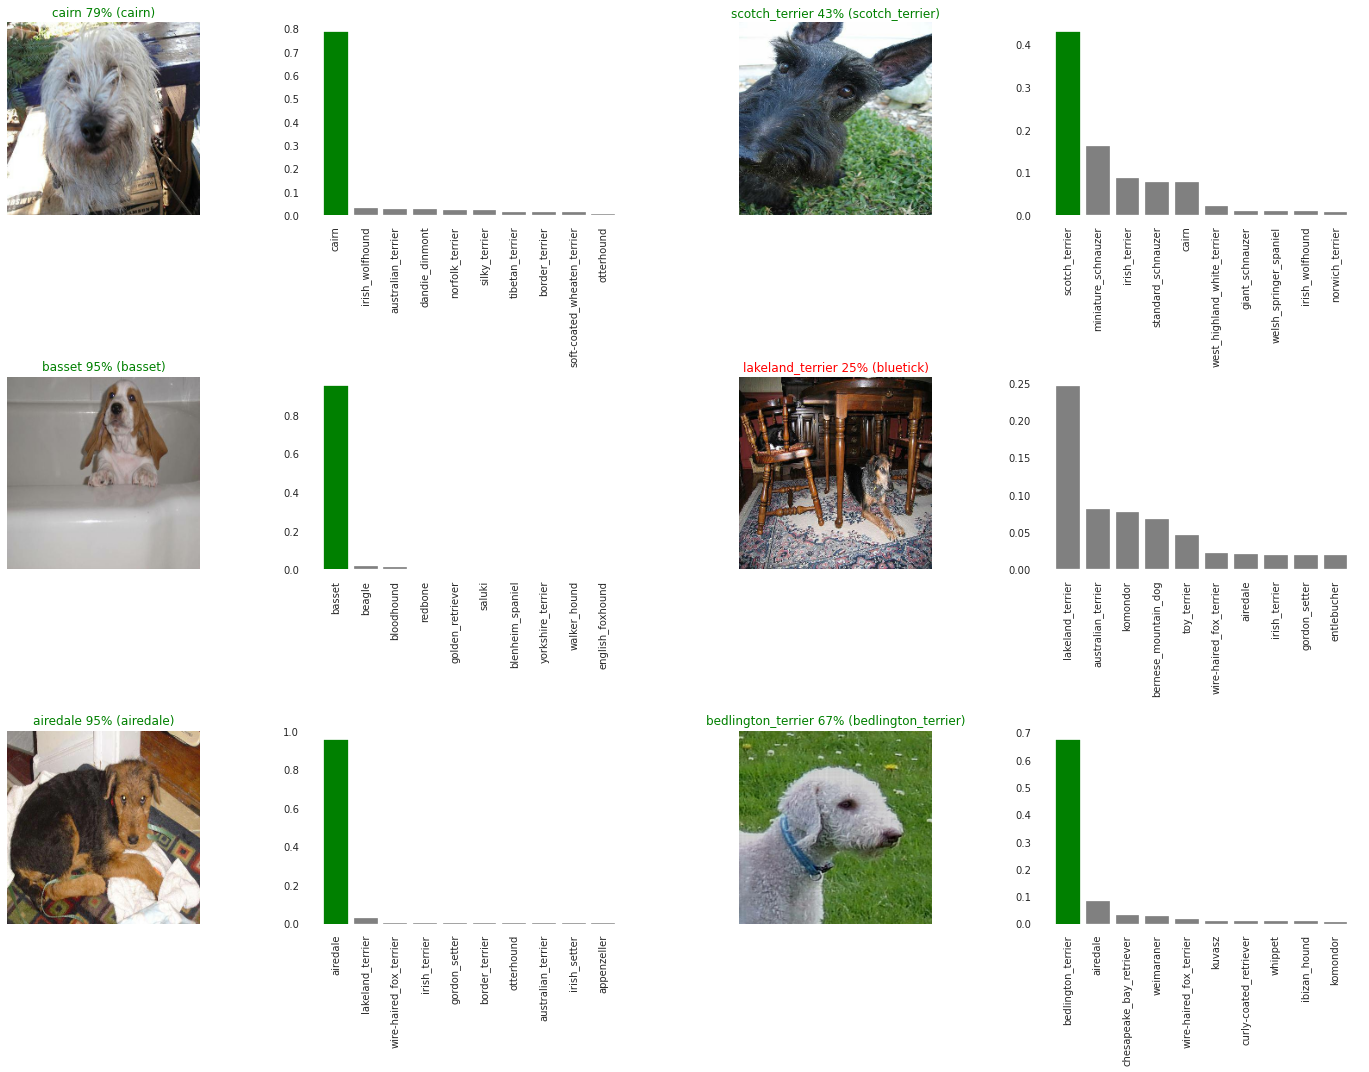

In [70]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Training a model (on the full data)

Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to `X` and all of the training labels to `y`. Let's check them out.

In [71]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [72]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [73]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

To monitor the model whilst it trains, we'll load TensorBoard (it should update every 30-seconds or so whilst the model trains).

In [74]:
%tensorboard --logdir ./logs


Reusing TensorBoard on port 6006 (pid 1272), started 0:14:40 ago. (Use '!kill 1272' to kill it.)

In [75]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 30s 95ms/step - loss: 2.5394 - accuracy: 0.4443
Epoch 2/100
320/320 [==============================] - 30s 93ms/step - loss: 0.9042 - accuracy: 0.7685
Epoch 3/100
320/320 [==============================] - 29s 92ms/step - loss: 0.6550 - accuracy: 0.8218
Epoch 4/100
320/320 [==============================] - 30s 93ms/step - loss: 0.5437 - accuracy: 0.8467
Epoch 5/100
320/320 [==============================] - 30s 93ms/step - loss: 0.4753 - accuracy: 0.8690
Epoch 6/100
320/320 [==============================] - 30s 93ms/step - loss: 0.4253 - accuracy: 0.8838
Epoch 7/100
320/320 [==============================] - 29s 91ms/step - loss: 0.3871 - accuracy: 0.8944
Epoch 8/100
320/320 [==============================] - 29s 92ms/step - loss: 0.3559 - accuracy: 0.9056
Epoch 9/100
320/320 [==============================] - 30s 93ms/step - loss: 0.3304 - accuracy: 0.9156
Epoch 10/100
320/320 [==============================] - 30s 93ms/step - l

320/320 [==============================] - 29s 90ms/step - loss: 0.0541 - accuracy: 0.9976
Epoch 80/100
320/320 [==============================] - 30s 95ms/step - loss: 0.0535 - accuracy: 0.9976
Epoch 81/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0528 - accuracy: 0.9973
Epoch 82/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0522 - accuracy: 0.9977
Epoch 83/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0515 - accuracy: 0.9976
Epoch 84/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0509 - accuracy: 0.9974
Epoch 85/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0504 - accuracy: 0.9978
Epoch 86/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0497 - accuracy: 0.9976
Epoch 87/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0493 - accuracy: 0.9981
Epoch 88/100
320/320 [==============================] - 30s 94ms/step - loss:

## Saving and reloading a model


In [76]:
# creating a function to save the model to use it in the future without training
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("./",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [77]:
# creating a function to reload a trained model 
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [78]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: ./20210104-08491609750160-all-images-Adam.h5...


'./20210104-08491609750160-all-images-Adam.h5'

In [82]:
# Load in the full model
loaded_full_model = load_model('./20210104-08491609750160-all-images-Adam.h5')

Loading saved model from: ./20210104-08491609750160-all-images-Adam.h5


### Making predictions on the test dataset
To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [83]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "../input/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:5]

['../input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '../input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '../input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '../input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '../input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg']

In [84]:
# How many test images are there?
len(test_filenames)

10357

In [85]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [86]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=-1)

In [87]:
# Check out the test predictions
test_predictions[:10]

array([[1.66786709e-08, 1.27698017e-11, 1.71674330e-07, ...,
        2.28297104e-05, 1.17433734e-08, 1.67075413e-07],
       [1.32445097e-11, 1.00657495e-07, 1.10221603e-10, ...,
        1.45302920e-07, 1.11237097e-09, 1.94048284e-11],
       [1.40004648e-08, 3.97832337e-05, 1.84387154e-08, ...,
        4.06501044e-07, 2.55678784e-10, 2.96238234e-09],
       ...,
       [1.58064893e-06, 1.09970881e-06, 1.23044896e-09, ...,
        1.32427358e-08, 7.40964512e-11, 7.33510405e-11],
       [6.00574946e-04, 1.94777783e-07, 2.11324277e-05, ...,
        8.77092043e-06, 3.16275909e-05, 5.56861642e-06],
       [5.85701656e-08, 1.78105083e-07, 1.60794311e-08, ...,
        1.82529760e-08, 1.51106452e-08, 1.50105670e-08]], dtype=float32)

### Preparing test dataset predictions for Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:
*   Create a pandas DataFrame with an ID column as well as a column for each dog breed.
*   Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.


In [88]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [89]:
# Append test image ID's to predictions DataFrame
test_path = "../input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,1.66787e-08,1.27698e-11,1.71674e-07,3.08144e-08,0.306632,3.84279e-09,4.95358e-07,1.805e-05,6.42771e-09,...,7.43252e-08,7.20544e-06,2.20385e-08,3.87573e-08,8.40186e-10,9.93665e-10,3.88147e-08,2.28297e-05,1.17434e-08,1.67075e-07
1,f7a32505c12649183c5991ecfa7d68b3,1.32445e-11,1.00657e-07,1.10222e-10,4.61965e-10,1.34021e-08,1.786e-08,5.2434e-09,1.20262e-08,2.07405e-06,...,1.86817e-09,3.05948e-10,4.05116e-05,1.76138e-06,9.57677e-10,3.24658e-11,1.74248e-11,1.45303e-07,1.11237e-09,1.94048e-11
2,bc6d50ffb4644feb34530aa58943e85b,1.40005e-08,3.97832e-05,1.84387e-08,9.54218e-07,2.48912e-08,3.65115e-09,1.72105e-09,1.85844e-09,2.10001e-07,...,1.5765e-09,9.48055e-11,6.62434e-10,2.80454e-08,1.87821e-07,5.93937e-09,2.01055e-10,4.06501e-07,2.55679e-10,2.96238e-09
3,7cbc041e79135a572aad87904b5c9c57,2.50971e-09,8.34702e-10,6.08555e-11,8.77244e-09,1.08613e-05,8.50266e-07,5.13439e-08,1.8051e-08,1.34171e-10,...,2.2019e-08,7.13391e-07,3.88634e-09,5.67035e-10,0.000333398,4.87099e-10,1.23933e-09,0.000344816,2.21038e-07,8.80694e-09
4,f3b603f10d6a344f0395fb46b242ff8e,7.9766e-10,2.58631e-09,2.32624e-10,1.98517e-07,1.39361e-09,4.56514e-07,3.22143e-09,1.59527e-09,8.01969e-07,...,5.68748e-10,1.1109e-09,1.39341e-08,1.52826e-07,4.78481e-10,0.998904,7.84575e-09,1.33888e-09,6.70962e-09,1.31193e-09


In [91]:
preds_df.to_csv("./full_submission_1_mobilienetV2_adam.csv",
                 index=False)